In [2]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from datasim.ecg.ecg_simulate import *
from datasim.scg.scg_simulate import *
import pywt
from utils import *

In [50]:
def send_vital_result(group, mac,timestamp, hr, rr, bph, bpl, movement, occupancy, occ_timestamp, alert, alert_timestamp):
    topic="/" + group + "/" + mac + "/vital"
 
    payload ="timestamp=" + str(timestamp)

    if hr != -1:
        payload += "; heartrate=" + str(hr) 
    if rr != -1:
        payload += "; respiratoryrate=" + str(rr) 
    if bph != -1:
        payload += "; systolic=" + str(bph) 
    if bpl != -1:
        payload += "; diastolic=" + str(bpl) 
    
    if movement != -1:
        payload += "; movement=" + str(movement)
    
    for index, oc in enumerate(occupancy):
        payload += "; timestamp=" + str(occ_timestamp + index*10**9) # assuming timestamp in nano seconds
        payload += "; occupancy=" + str(occupancy[index])
    
    if alert != -1:
        payload += "; timestamp=" + str(alert_timestamp) + "; alert=" + str(alert)

    if not DRY_RUN_MODE:
        mqtt_dedicated_pubish.publish(topic, payload, qos=1)
        if debug:
            global mqtt_publishing_cnt
            mqtt_publishing_cnt +=1
            if mqtt_publishing_cnt % 100 ==0:
                print(f"mqtt_publishing_cnt={mqtt_publishing_cnt}")
    else:
        # print(topic)
        pass
    return

In [52]:
data = np.load("hr_156.0_rr_10.0_2025-01-27 14:02:50.507413-05:00.npy")

In [53]:
data.shape

(1, 4103)

In [54]:
data = data.reshape(-1,1)

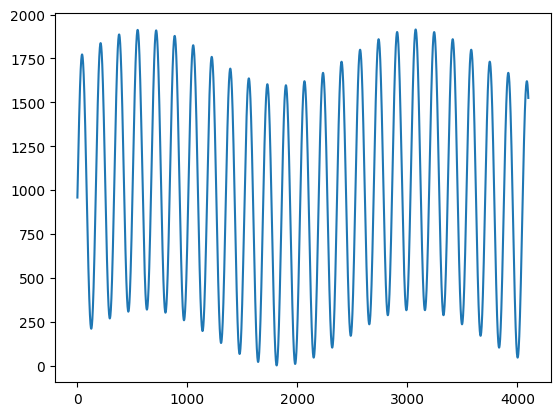

In [55]:
plt.plot(data[:-3])

In [34]:
def sine_gen_with_rr (amp, samples, duration, hr, rr):
    freq_hr = hr/60       # Frequency in Hz
    freq_rr = rr/60
    hr_amp = amp       # Amplitude of the sine wave
    rr_amp = 0.2*hr_amp
    sampling_rate = samples # Sampling rate in Hz
    duration = duration        # Duration in seconds
    
    # Generate the time axis
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)


    # Generate the sine wave
    rr_wave = rr_amp + (rr_amp*np.sin(2 * np.pi * freq_rr * t))
    hr_wave = hr_amp + (hr_amp * np.sin(2 * np.pi * freq_hr * t))
    
    sine_wave = rr_wave + hr_wave
    return sine_wave

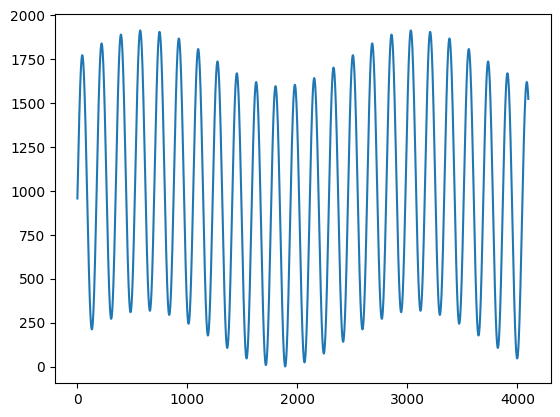

In [35]:
a = sine_gen_with_rr(798, 410, 10, 140, 10)
plt.plot(a)

In [23]:
def sine_gen_with_rr_v2(amp, samples, duration, hr, rr):
    wave=[]
    f_hr = hr/60
    f_rr = rr/60
    amp_rr = amp*0.2
    for i in range(0,duration*samples):
        val_hr = amp + int(amp * (math.sin(2 * math.pi * f_hr * i/samples)))
        val_rr = amp_rr + int(amp_rr * (math.sin(2 * math.pi * f_rr * i/samples)))
        val = val_hr + val_rr
        wave.append(val)    
    
    return wave

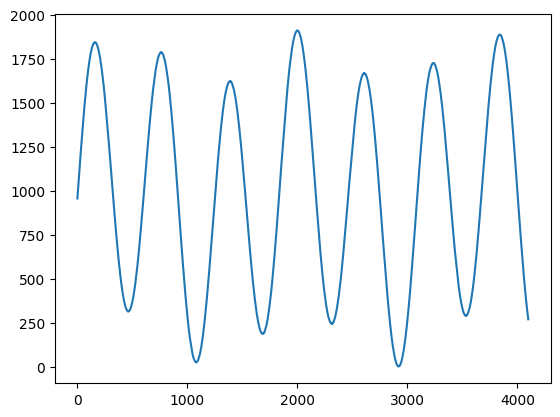

In [26]:
a = sine_gen_with_rr_v2(798, 410, 10, 40, 15)
plt.plot(a[:])

In [27]:
len(a)

4100

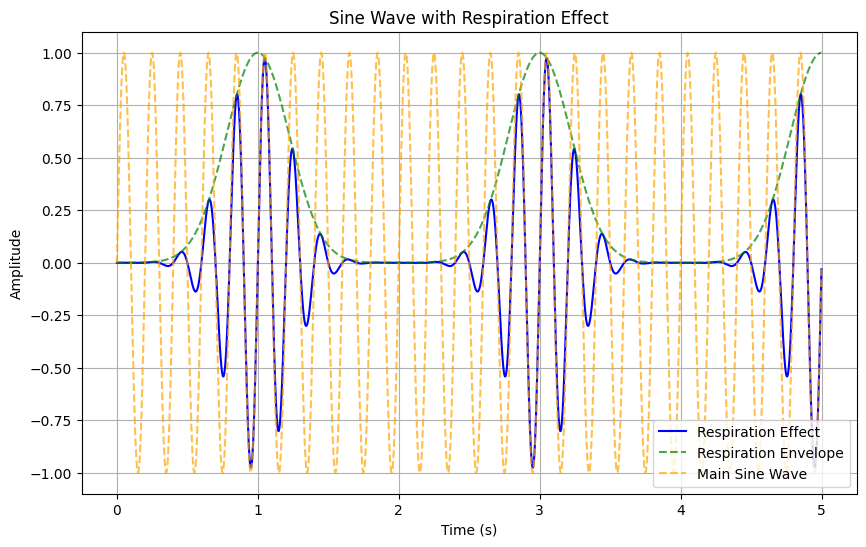

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 1000  # Sampling frequency (samples per second)
duration = 5  # Duration (seconds)
t = np.linspace(0, duration, int(fs * duration), endpoint=False)  # Time vector

# Main sine wave parameters
main_freq = 60/60  # Frequency of the main sine wave (Hz)

# Respiration-like envelope function (Gaussian-inspired)
respiration_cycle_duration = 15/60  # Duration of one "breath" (seconds)
respiration_envelope = np.exp(-((t % respiration_cycle_duration) - respiration_cycle_duration / 2)**2 / 0.1)

# Main sine wave
main_wave = np.sin(2 * np.pi * main_freq * t)

# Apply the respiration envelope
respiration_effect_wave = respiration_envelope * main_wave

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, respiration_effect_wave, label="Respiration Effect", color="blue")
plt.plot(t, respiration_envelope, label="Respiration Envelope", color="green", linestyle="--", alpha=0.7)
plt.plot(t, main_wave, label="Main Sine Wave", color="orange", linestyle="--", alpha=0.7)
plt.title("Sine Wave with Respiration Effect")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()


In [6]:
def sine_gen_with_rr (amp, samples, duration, hr, rr):
    freq_hr = hr/60       # Frequency in Hz
    freq_rr = rr/60
    hr_amp = amp       # Amplitude of the sine wave
    rr_amp = 0.2*hr_amp
    sampling_rate = samples # Sampling rate in Hz
    duration = duration        # Duration in seconds
    
    # Generate the time axis
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

    for i in range(samples):
    # Generate the sine wave
        rr_wave = rr_amp + (rr_amp*np.sin(2 * np.pi * freq_rr * t))
        hr_wave = hr_amp + (hr_amp * np.sin(2 * np.pi * freq_hr * t))
    
    sine_wave = rr_wave + hr_wave
    return sine_wave